#Library Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud #To visualize the text data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer #To tokenize the text data
from tensorflow.keras.preprocessing.sequence import pad_sequences #To pad dataset that is not long enough (standardization)
from tensorflow.keras.models import Sequential #Feeding model layers here
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#Import Data

##Fake News

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/mnkd246/fake-news-detection/main/news_dataset/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<ipython-input-7-1e659eadcf57>:3: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.countplot(data=fake, x='subject', palette=palette, hue='subject')


<Axes: xlabel='subject', ylabel='count'>

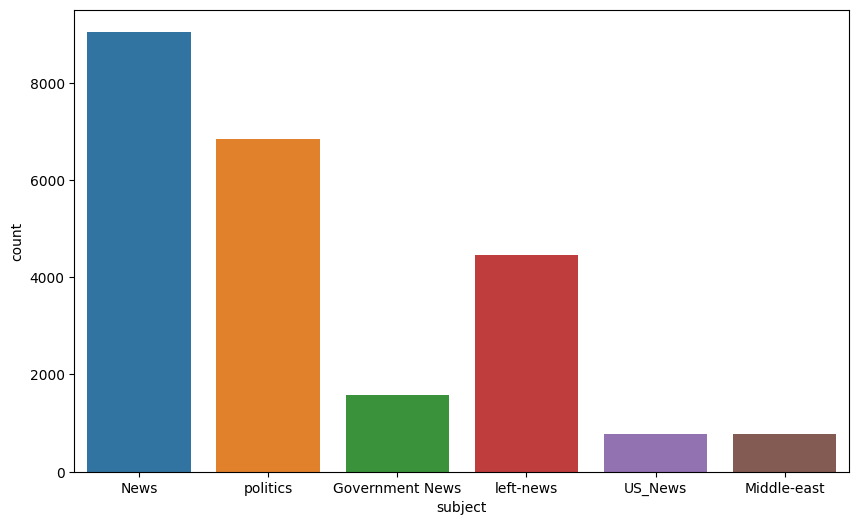

In [ ]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette()
sns.countplot(data=fake, x='subject', palette=palette, hue='subject')

**Wordcloud**

In [ ]:
fake['text'].tolist()

['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t e

From the list, it needs to be merged into a single text data

In [ ]:
text = ' '.join(fake['text'].tolist()) #The ' ' joins the text data with a space (can be comma, etc)

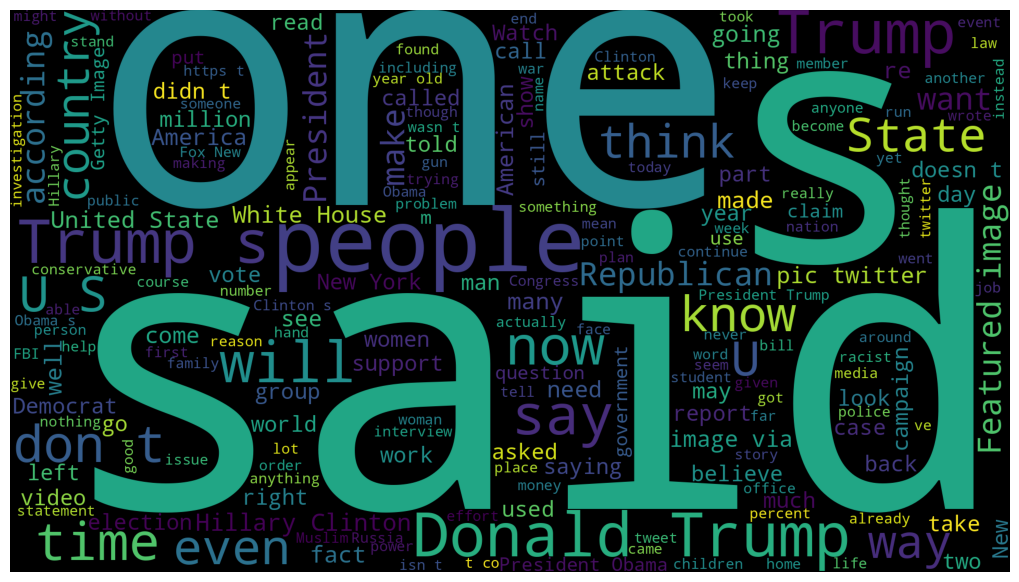

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##Real News

In [ ]:
real = pd.read_csv('https://raw.githubusercontent.com/mnkd246/fake-news-detection/main/news_dataset/True.csv')

In [ ]:
text = ' '.join(real['text'].tolist())

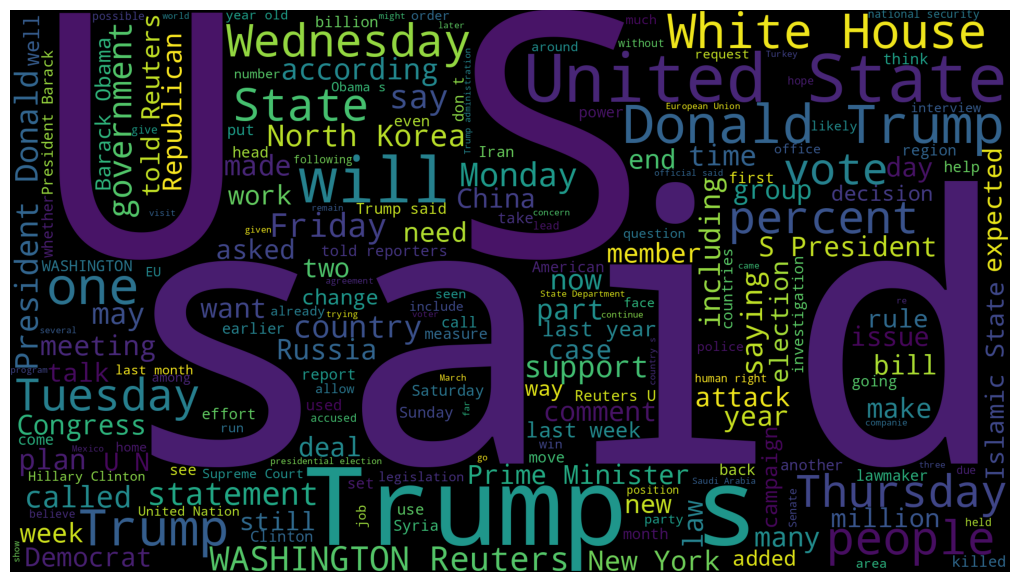

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

One notable difference between fake and real news word clouds is the appearance of "Washington Reuters", which is only on real news. Washington Reuters is very well known news service that provides reports from around the world to newpapers and broadcasters.

So unlike the fake news set, real news is more likely to have a source of publication.

Also, some texts are tweets from Twitter. Some texts don't contain any publication information.

#Cleaning Data

First, I will be removing Reuters or Twitter Tweet information from the text

In [ ]:
real.sample(5)

,title,text,subject,date
14495,Iraqi forces recapture last Islamic State-held...,BAGHDAD (Reuters) - Iraqi forces on Friday cap...,worldnews,"November 17, 2017"
9700,"Exiting 2016 race, Republican Cruz leaves hims...","INDIANAPOLIS, Ind. (Reuters) - U.S. Republican...",politicsNews,"May 4, 2016"
19436,Colombia arrests local director of Portugal's ...,LISBON (Reuters) - Colombian police have arres...,worldnews,"September 21, 2017"
3359,Filmmaker Michael Moore launches 'TrumpiLeaks'...,LOS ANGELES (Reuters) - Documentary filmmaker ...,politicsNews,"June 6, 2017"
10640,Exclusive: Super PACs backing Republican Cruz ...,WASHINGTON (Reuters) - Making a final push tow...,politicsNews,"February 26, 2016"


In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970, axis=0)

In [ ]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

Fake news rows with empty data:

In [ ]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

#Preprocessing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text', 'class']]

In [ ]:
fake = fake[['text', 'class']]

In [ ]:
data = real.append(fake, ignore_index=True)

<ipython-input-32-45d5ced910ac>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = real.append(fake, ignore_index=True)


In [ ]:
data.sample(5)

,text,class
27864,watch: gay cyclist shuts down hate preacher w...,0
5057,fbi director comey at cyber conference: 'you'r...,1
138,net neutrality repeal gives democrats fresh wa...,1
16926,kremlin: syria peoples' congress being 'active...,1
19041,couple defy hurricane maria on roof to save pe...,1


Now, we need to remove special characters (colons, etc). This will be done using kgptalkie preprocessing package

In [ ]:
# Dependencies
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-03khupfx
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-03khupfx
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=4f83a10fe4b505eb8ae8cb60677f4a81d66a11ba314e1ae00b1b238682715b13
  Stored in di

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

#Vectorization - Word2Vec

The next step is converting the text data to numerical data (aka tokenization)

Word2Vec is one of the most popular techniques to learn word embeddings using shallow neural networks.

Word embedding is the most popular representation of document vocabulary.

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
DIM = 100 #each word will be converted to a sequence of 100 vectors
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, min_count = 1)

In [ ]:
len(w2v_model.wv.key_to_index)

231872

In [ ]:
w2v_model.wv.key_to_index

{'the': 0,
 'to': 1,
 'of': 2,
 'a': 3,
 'and': 4,
 'in': 5,
 'that': 6,
 'on': 7,
 'for': 8,
 's': 9,
 'is': 10,
 'he': 11,
 'said': 12,
 'trump': 13,
 'it': 14,
 'with': 15,
 'was': 16,
 'as': 17,
 'his': 18,
 'by': 19,
 'has': 20,
 'be': 21,
 'have': 22,
 'not': 23,
 'from': 24,
 'this': 25,
 'at': 26,
 'are': 27,
 'who': 28,
 'us': 29,
 'an': 30,
 'they': 31,
 'i': 32,
 'but': 33,
 'we': 34,
 'would': 35,
 'president': 36,
 'about': 37,
 'will': 38,
 'their': 39,
 'had': 40,
 'you': 41,
 't': 42,
 'been': 43,
 'were': 44,
 'people': 45,
 'more': 46,
 'or': 47,
 'after': 48,
 'which': 49,
 'she': 50,
 'her': 51,
 'one': 52,
 'if': 53,
 'its': 54,
 'out': 55,
 'all': 56,
 'what': 57,
 'state': 58,
 'when': 59,
 'new': 60,
 'also': 61,
 'up': 62,
 'there': 63,
 'over': 64,
 'no': 65,
 'house': 66,
 'donald': 67,
 'our': 68,
 'states': 69,
 'clinton': 70,
 'obama': 71,
 'government': 72,
 'can': 73,
 'just': 74,
 'him': 75,
 'so': 76,
 'than': 77,
 'republican': 78,
 'other': 79,
 'som

In [ ]:
w2v_model.wv.most_similar('us')

[('american', 0.6377666592597961),
 ('russian', 0.5476788282394409),
 ('nato', 0.5400013327598572),
 ('iranian', 0.5314833521842957),
 ('iran', 0.5060639381408691),
 ('turkish', 0.48831164836883545),
 ('powerabuse', 0.48636022210121155),
 ('our', 0.4860076308250427),
 ('chinese', 0.47541144490242004),
 ('russias', 0.4721318483352661)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X has now been converted to a set of sequence

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
# tokenizer.word_index

#Padding

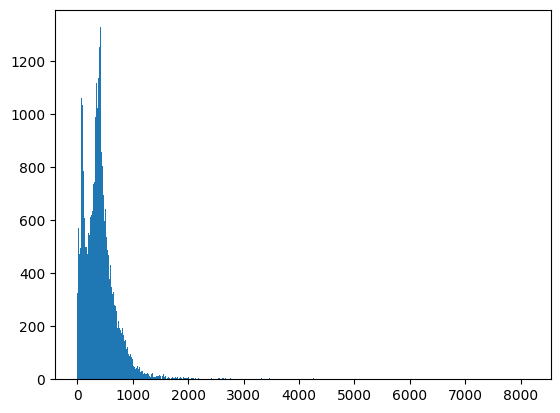

In [ ]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

Most news have words less than 1000 words, so we can shorten the news with more than 1000 words

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000]) #amount of news that have more than 1000 words

1581

In [ ]:
maxlen = 500
X = pad_sequences(X, maxlen=maxlen)

Now the length of ANY index is 500, even those that had less than 500 words. This is the padding process

#LSTM Modelling

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(231873, 100)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid')) #since we only have 2 classes
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          23187300  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23304677 (88.90 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 23187300 (88.45 MB)
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2024)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 20s 22ms/step - loss: 0.1659 - acc: 0.9364 - val_loss: 0.1148 - val_acc: 0.9623
Epoch 2/6
737/737 [==============================] - 15s 21ms/step - loss: 0.0844 - acc: 0.9708 - val_loss: 0.0651 - val_acc: 0.9795
Epoch 3/6
737/737 [==============================] - 15s 21ms/step - loss: 0.0502 - acc: 0.9835 - val_loss: 0.0425 - val_acc: 0.9862
Epoch 4/6
737/737 [==============================] - 17s 23ms/step - loss: 0.0303 - acc: 0.9899 - val_loss: 0.1061 - val_acc: 0.9634
Epoch 5/6
737/737 [==============================] - 16s 22ms/step - loss: 0.0257 - acc: 0.9917 - val_loss: 0.0248 - val_acc: 0.9910
Epoch 6/6
737/737 [==============================] - 19s 25ms/step - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0225 - val_acc: 0.9921


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

351/351 [==============================] - 3s 7ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9929621380846325

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5884
           1       0.99      0.99      0.99      5341

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



#Performing Model on Custom Text Data

In [ ]:
# x = ['Only photo I will tweet. CPR being performed on the soldier now. I heard four shots. #ottawa']
# x = tokenizer.texts_to_sequences(x)
# x = pad_sequences(x, maxlen=maxlen)

In [ ]:
# (model.predict(x) >= 0.5).astype(int)

##Sample News

In [ ]:
# news_df = pd.read_csv('https://raw.githubusercontent.com/joshndala/fake-news-detection/main/sample_dataset/sampled_dataset.csv')

# news_df['text'] = news_df['text'].astype(str)

# preprocessed_news = [ps.remove_special_chars(text) for text in news_df['text'].tolist()]

In [ ]:
# X_new = tokenizer.texts_to_sequences(preprocessed_news)
# X_new_padded = pad_sequences(X_new, maxlen=maxlen)

In [ ]:
# predictions = model.predict(X_new_padded)
# predicted_classes = (predictions >= 0.5).astype(int)

# news_df['Predicted Class'] = predicted_classes

In [ ]:
# true_labels = news_df['class'].values
# print("Accuracy:", accuracy_score(true_labels, predicted_classes))
# print(classification_report(true_labels, predicted_classes))

##Tweets

In [ ]:
# Removing emojis from the tweets
import re

def remove_emojis(text):
    # Regex to match most emojis in the range of Unicode characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
tweets_df = pd.read_csv('https://raw.githubusercontent.com/joshndala/fake-news-detection/main/twitter_dataset/twitter_data.csv')
tweet_texts = tweets_df['text'].tolist()

#remove special characters
preprocessed_tweets = [remove_emojis(ps.remove_special_chars(text)) for text in tweet_texts]

In [ ]:
X_new = tokenizer.texts_to_sequences(preprocessed_tweets)
X_new_padded = pad_sequences(X_new, maxlen=maxlen)

In [ ]:
predictions = model.predict(X_new_padded)
predicted_classes = (predictions >= 0.5).astype(int)

tweets_df['Predicted Class'] = predicted_classes

73/73 [==============================] - 1s 7ms/step


In [ ]:
true_labels = tweets_df['class'].values
print("Accuracy:", accuracy_score(true_labels, predicted_classes))
print(classification_report(true_labels, predicted_classes))

Accuracy: 0.5060658578856152
              precision    recall  f1-score   support

           0       0.50      0.97      0.66      1150
           1       0.60      0.05      0.09      1158

    accuracy                           0.51      2308
   macro avg       0.55      0.51      0.37      2308
weighted avg       0.55      0.51      0.37      2308



#Other Misinformation Dataset

In [ ]:
misinfo_df = pd.read_excel('Misinfo_Dataset.xlsx')
misinfo_df.head()

,Text,Translation,Class label,Unnamed: 3,Verified
0,সাধারণত প্রতি ২৮ থেকে ৩৫ দিন পর পর একজন নারীর ...,A woman usually has her period every 28 to 35 ...,Valid Information,NaN,NaN
1,১২ বছর থেকে ৫৫ বছর বয়সী নারীদের ক্ষেত্রে এমনটি...,The same is true for women between the ages of...,Valid Information,NaN,NaN
2,প্রাপ্তবয়স্ক একজন নারীর নিয়মিত ও সময়মতো মাসিক ...,Regular and timely menstruation in an adult wo...,Valid Information,NaN,NaN
3,"মাসিক যদি অনিয়মিত হয়ে পড়ে, তার মানে হয়তো শারীর...","If menstruation becomes irregular, it may mean...",Valid Information,NaN,NaN
4,বেশিরভাগ নারীর মাসিকের চক্র একই থাকে।,Most women have the same menstrual cycle.,Valid Information,NaN,NaN


In [ ]:
misinfo_df['Class label '].value_counts()

Valid Information    2469
Misinformation       2019
Name: Class label , dtype: int64

In [ ]:
def get_class_label(label):
  if label == 'Valid Information':
    return 1
  else:
    return 0

misinfo_df['class'] = misinfo_df['Class label '].apply(get_class_label)
misinfo_df.head()

,Text,Translation,Class label,Unnamed: 3,Verified,class
0,সাধারণত প্রতি ২৮ থেকে ৩৫ দিন পর পর একজন নারীর ...,A woman usually has her period every 28 to 35 ...,Valid Information,NaN,NaN,1
1,১২ বছর থেকে ৫৫ বছর বয়সী নারীদের ক্ষেত্রে এমনটি...,The same is true for women between the ages of...,Valid Information,NaN,NaN,1
2,প্রাপ্তবয়স্ক একজন নারীর নিয়মিত ও সময়মতো মাসিক ...,Regular and timely menstruation in an adult wo...,Valid Information,NaN,NaN,1
3,"মাসিক যদি অনিয়মিত হয়ে পড়ে, তার মানে হয়তো শারীর...","If menstruation becomes irregular, it may mean...",Valid Information,NaN,NaN,1
4,বেশিরভাগ নারীর মাসিকের চক্র একই থাকে।,Most women have the same menstrual cycle.,Valid Information,NaN,NaN,1


In [ ]:
misinfo_data = misinfo_df[["Translation", "class"]]
misinfo_data.rename(columns={"Translation": "text"}, inplace=True)
misinfo_data['text'] = misinfo_data['text'].apply(lambda x: str(x).lower())
misinfo_data.head()

<ipython-input-85-4c526c49a834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_data.rename(columns={"Translation": "text"}, inplace=True)
<ipython-input-85-4c526c49a834>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_data['text'] = misinfo_data['text'].apply(lambda x: str(x).lower())


,text,class
0,a woman usually has her period every 28 to 35 ...,1
1,the same is true for women between the ages of...,1
2,regular and timely menstruation in an adult wo...,1
3,"if menstruation becomes irregular, it may mean...",1
4,most women have the same menstrual cycle.,1


In [ ]:
misinfo_text = misinfo_data['text'].tolist()
preprocessed_misinfo = [ps.remove_special_chars(text) for text in misinfo_text]

In [ ]:
X_new = tokenizer.texts_to_sequences(preprocessed_misinfo)
X_new_padded = pad_sequences(X_new, maxlen=maxlen)

In [ ]:
predictions = model.predict(X_new_padded)
predicted_classes = (predictions >= 0.5).astype(int)

misinfo_data['Predicted Class'] = predicted_classes

141/141 [==============================] - 2s 15ms/step


<ipython-input-88-fab3e9ea6a01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_data['Predicted Class'] = predicted_classes


In [ ]:
true_labels = misinfo_data['class'].values
print("Accuracy:", accuracy_score(true_labels, predicted_classes))
print(classification_report(true_labels, predicted_classes))

Accuracy: 0.46008869179600886
              precision    recall  f1-score   support

           0       0.46      0.98      0.62      2041
           1       0.64      0.03      0.06      2469

    accuracy                           0.46      4510
   macro avg       0.55      0.51      0.34      4510
weighted avg       0.56      0.46      0.31      4510

